In [15]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import(summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm

In [16]:
from pygam import(s as s_gam, 
                 l as l_gam,
                 f as f_gam,
                 LinearGAM,
                 LogisticGAM)
from ISLP.transforms import (BSpline, NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, 
                       degrees_of_freedom,
                       plot as plot_gam,
                       anova as anova_gam)

In [17]:
#Polynomial Regression and Step Functions
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']
poly_age = MS([poly('age', degree = 4)]).fit(Wage)
M = sm.OLS(y, poly_age.transform(Wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [10]:
age_grid = np.linspace(age.min(), 
                       age.max(),
                       100)
age_df = pd.DataFrame({'age': age_grid})


In [18]:
def plot_wage_fit(age_df,
                  basis,
                  title):
    X = basis.transform(Wage)
    Xnew = basis.transform(age_df)
    M = sm.OLS(y,X).fit()
    preds = M.get_prediction(Xnew)
    bands = preds.conf_int(alpha = 0.05)
    fig, ax = subplots(figsize = (8,8))
    ax.scatter(age,
              y,
              facecolor = 'gray',
              alpha = 0.5)
    for val, ls in zip([preds.predicted_mean,
                       bands[:,0],
                       bands[:,1]],
                      ['b','r--','r--']):
        ax.plot(age_df.values, val, ls, linewidth=3)
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel('Age', fontsize = 20);
    return ax

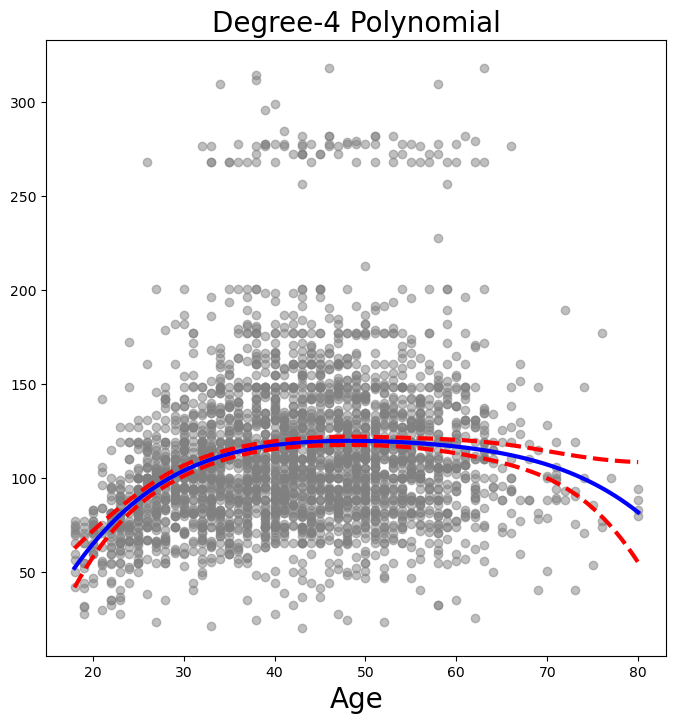

In [19]:
plot_wage_fit(age_df, poly_age, 'Degree-4 Polynomial');

In [20]:
models = [MS([poly('age', degree = d)])
         for d in range(1, 6)]
Xs = [model.fit_transform(Wage) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
          for X_ in Xs])


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


In [21]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


In [22]:
models = [MS(['education', poly('age', degree = d)])
         for d in range(1, 4)]
XEs = [model.fit_transform(Wage)
       for model in models]
anova_lm(*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


In [23]:
X = poly_age.transform(Wage)
high_earn = Wage['high_earn'] = y>250
glm = sm.OLS(y>250,
            X,
            family = sm.families.Binomial())
B = glm.fit()
summarize(B)

C:\Users\user\anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)


,coef,std err,t,P>|t|
intercept,0.0263,0.003,9.025,0.000
"poly(age, degree=4)[0]",0.5414,0.160,3.388,0.001
"poly(age, degree=4)[1]",-0.3545,0.160,-2.218,0.027
"poly(age, degree=4)[2]",-0.0613,0.160,-0.383,0.701
"poly(age, degree=4)[3]",-0.0472,0.160,-0.295,0.768


ValueError: too many values to unpack (expected 2)

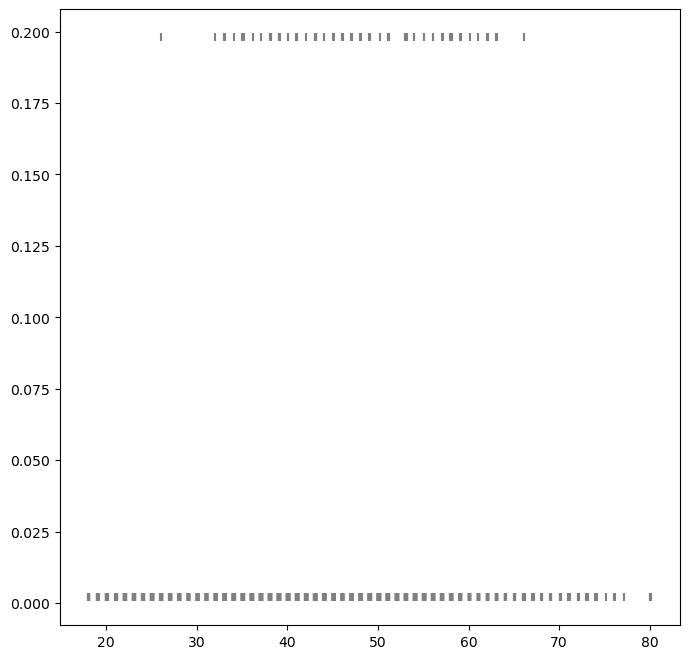

In [29]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha = 0.05)
fig, ax = subplots(figsize = (8,8))
rng = np.random.default_rng(0)
ax.scatter(age+
           0.2*rng.uniform(size=y.shape[0]),
           np.where(high_earn, 0.198, 0.002),
           fc = 'gray',
           marker = '|')
for val, ls in zip([preds.predicted_mean]cut,
                   bands[:, 0],
                   bands[:,1],
                   ['b','r--','r--']):
    ax.plot(age_df.values, val, ls, linewidth = 3)
ax.set_title('Degree-4 Polynomial', fontsize = 20)
ax.set_xlabel('Age', fontsize = 20)
ax.set_ylim([0,0.2])
ax.set_ylabel('P(Wage>250)', fontsize = 20);

In [30]:
cut_age = pd.qcut(age, 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())

,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0
